## Arrumando o Dataset

In [1]:
import os
import cv2

dataset_directory = ".\dataset"
images = []
labels = []

In [2]:
os.listdir(dataset_directory)

['andean', 'black', 'grizzly', 'malayanus', 'panda', 'polar', 'sloth', 'teddy']

In [3]:
for folder_name in os.listdir(dataset_directory):
    folder_path = os.path.join(dataset_directory, folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            resized_image = cv2.resize(image, (256, 256))
            images.append(resized_image)
            labels.append(folder_name);

In [4]:
print(len(images))
print(len(labels))

1526
1526


## Verificando se tudo ocorreu corretamente.

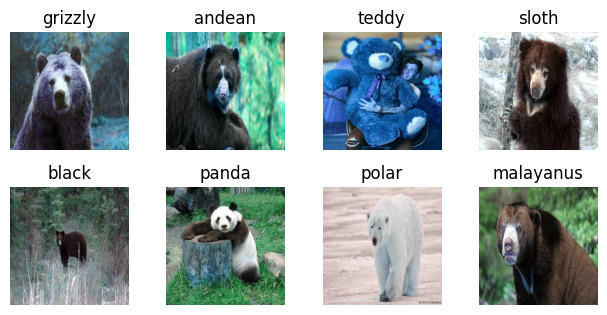

In [5]:
import numpy as np
import matplotlib.pyplot as plt

unique_labels = list(set(labels))
num_labels = len(unique_labels)
num_labels_per_line = 4
labels_array = np.array(labels)

for i, label in enumerate(unique_labels):
    index = labels_array.tolist().index(label)
    image = images[index]
    plt.subplot(num_labels // num_labels_per_line + 1, num_labels_per_line, i+1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
images = np.array(images)
images = images / 255.0
labels = np.array(labels)

## Dividindo em Dados de treinamento e Validação

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 1220
Testing set size: 306


## Padronizando os dados

In [8]:
X_train = X_train.reshape(len(X_train), 256, 256, 3)
X_test = X_test.reshape(len(X_test), 256, 256, 3)

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [10]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
print(y_train[0])
print(y_test[0])

[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]


In [12]:
from keras.models import Sequential
from keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation
from keras.initializers import he_normal
from keras.optimizers import Adam

## Criando Modelo 

In [13]:
from keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

model = Sequential(
    [
        base_model,
        Flatten(),
        Dense(256, activation='elu'),
        Dropout(0.2),
        Dense(8, activation='softmax')
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [14]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = 'model.keras',
    monitor ='val_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

## Treinando de fato o modelo

In [25]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/30
39/39 [==============================] - ETA: 0s - loss: 0.0084 - categorical_accuracy: 0.9975
Epoch 1: val_categorical_accuracy did not improve from 0.93137
39/39 [==============================] - 35s 896ms/step - loss: 0.0084 - categorical_accuracy: 0.9975 - val_loss: 0.6683 - val_categorical_accuracy: 0.9281
Epoch 2/30
39/39 [==============================] - ETA: 0s - loss: 0.0204 - categorical_accuracy: 0.9934
Epoch 2: val_categorical_accuracy improved from 0.93137 to 0.94118, saving model to model.keras
39/39 [==============================] - 39s 1s/step - loss: 0.0204 - categorical_accuracy: 0.9934 - val_loss: 0.5094 - val_categorical_accuracy: 0.9412
Epoch 3/30
39/39 [==============================] - ETA: 0s - loss: 0.0464 - categorical_accuracy: 0.9877
Epoch 3: val_categorical_accuracy did not improve from 0.94118
39/39 [==============================] - 37s 947ms/step - loss: 0.0464 - categorical_accuracy: 0.9877 - val_loss: 1.2201 - val_categorical_accuracy: 0.

## Visualizando os resultados

In [26]:
best_model_accuracy = max(history.history['categorical_accuracy'])
best_model_val_accuracy = max(history.history['val_categorical_accuracy'])

print("Training Accuracy :", best_model_accuracy)
print("Validation Accuracy :", best_model_val_accuracy)

Training Accuracy : 0.9975410103797913
Validation Accuracy : 0.9477124214172363


In [27]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_test_labels, y_pred_labels)

10/10 [==============================] - 6s 583ms/step


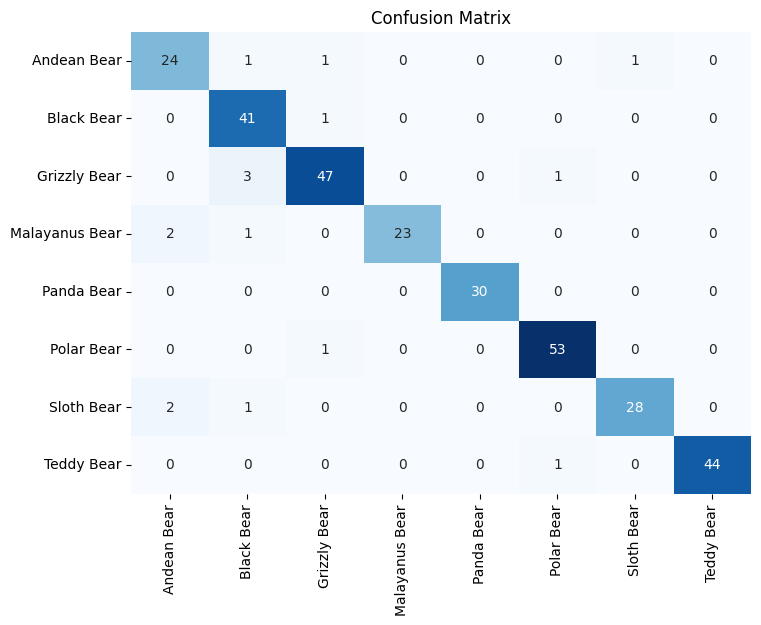

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_mtx,
    annot=True,
    cbar=False,
    fmt='d',
    cmap="Blues",
    xticklabels=['Andean Bear', 'Black Bear', 'Grizzly Bear', 'Malayanus Bear', 'Panda Bear', 'Polar Bear', 'Sloth Bear', 'Teddy Bear'],
    yticklabels=['Andean Bear', 'Black Bear', 'Grizzly Bear', 'Malayanus Bear', 'Panda Bear', 'Polar Bear', 'Sloth Bear', 'Teddy Bear'],
)

plt.title('Confusion Matrix')
plt.show()

In [29]:
from sklearn.metrics import recall_score

recall = recall_score(y_test_labels, y_pred_labels, average=None)
print("Recall:", recall)

Recall: [0.88888889 0.97619048 0.92156863 0.88461538 1.         0.98148148
 0.90322581 0.97777778]
